# Museums in the Pandemic - Social media analytics

**Authors**: Andrea Ballatore (KCL)

**Abstract**: Analysis of social media data

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [119]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
import spacy
import re
from termcolor import colored
import matplotlib.dates as mdates
import sys
from matplotlib.colors import ListedColormap
import numpy as np
import calplot
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number
from analytics.text_models import derive_new_attributes_matches, get_all_matches_from_db, get_indicator_annotations
from museums import get_museums_w_web_urls, get_twitter_facebook_links

cur_folder = out_folder + 'data/analysis/'

print('env ok')

Conda env: mip_v1
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks_py
env ok


## Connect to DB

It needs the DCS VPN active to work.

In [2]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


## Load museum info


In [3]:
def get_extra_attributes(df):
    df['governance_simpl'] = df['governance'].str.split(':').str[0].str.lower()
    df['subject_matter_simpl'] = df['subject_matter'].str.split(':').str[0]
    df['country'] = df['admin_area'].str.split('/').str[1]
    df['region'] = df['admin_area'].str.split('/').str[2]
    df['region'] = np.where(df['country'] == 'England', df['region'], df['country'])
    df['region'] = df['region'].str.replace('\(English Region\)','')
    print(df['governance_simpl'].value_counts())
    print(df['country'].value_counts())
    print(df['region'].value_counts())
    print(df['subject_matter_simpl'].value_counts())
    return df

# load museums
df = get_museums_w_web_urls(out_folder)
print("museums url N:",len(df))
attr_df = load_input_museums_wattributes(out_folder)
df = pd.merge(df, attr_df, on='muse_id', how='left')
print("museum df with attributes: len", len(df))
mus_df = df.rename(columns={'muse_id':'museum_id','musname_x':'musname'})
del df
print(len(mus_df), mus_df.columns)

links_df = get_twitter_facebook_links(out_folder)[['museum_id', 'twitter_id', 'facebook_pages']]
mus_df = mus_df.merge(links_df, on='museum_id', how='left')
mus_df = get_extra_attributes(mus_df)
del links_df
#print(len(mus_df), mus_df.columns)
mus_df.sample(50)

museums urls: ../../data/museums/museum_websites_urls-v3.tsv
nationaltrust.org.uk       179
english-heritage.org.uk     52
no_resource.                33
visitscotland.com           24
nts.org.uk                  21
                          ... 
glynnvivian.co.uk            1
glynde.co.uk                 1
gwsr.com                     1
gloucesterquays.co.uk        1
smithsonfarm.co.uk           1
Name: domain, Length: 2441, dtype: int64
get_museums_w_web_urls Museums=3344 URLs=3344
museums url N: 3344
Index(['musname', 'muse_id', 'town', 'postcode', 'accreditation', 'governance',
       'size', 'subject_matter', 'closing_date', 'provenance',
       'deprivation_index', 'geodemographic_group', 'geodemographic_subgroup',
       'admin_area'],
      dtype='object')
loaded museums w attributes (open): 3341 data/museums/museums_wattributes-2020-02-23.tsv
museum df with attributes: len 3344
3344 Index(['museum_id', 'musname', 'town_x', 'url', 'url_source', 'Unnamed: 5',
       'domain', 'm

/var/folders/f6/jwz5v525215521t6qbnxcdh80000gn/T/ipykernel_69980/3366711016.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['region'] = df['region'].str.replace('\(English Region\)','')


,museum_id,musname,town_x,url,url_source,Unnamed: 5,domain,musname_y,town_y,postcode,...,deprivation_index,geodemographic_group,geodemographic_subgroup,admin_area,twitter_id,facebook_pages,governance_simpl,subject_matter_simpl,country,region
2855,mm.misc.011,The Old Lytham Lifeboat House,Lytham,http://www.lythamwindmill.co.uk/The-Old-Lytham...,pred,NaN,lythamwindmill.co.uk,The Old Lytham Lifeboat House,Lytham,FY8 5LD,...,6.0,English and Welsh Countryside,Older Farming Communities,/England/North West (English Region)/Lancashir...,no_resource,en-gb.facebook.com/lythamlifeboatmuseum,independent,Sea and seafaring,England,North West
1035,mm.domus.SC230,Gairloch Heritage Museum,Gairloch,https://www.gairlochmuseum.org/,pred,NaN,gairlochmuseum.org,Gairloch Heritage Museum,Gairloch,IV21 2BP,...,6.0,Scottish Countryside,Scottish Countryside,/Scotland/Highland (Scottish Council Area),twitter.com/gairlochmuseum,"['www.facebook.com/gairlochmuseum', 'en-gb.fac...",independent,Local Histories,Scotland,Scotland
1204,mm.wiki.208,Hatfield House,Hatfield,https://www.hatfield-house.co.uk/,manual,NaN,hatfield-house.co.uk,Hatfield House,Hatfield,AL9 5NQ,...,10.0,Larger Towns and Cities,Larger Towns and Cities,/England/East of England (English Region)/Hert...,twitter.com/hatfield_house,['www.facebook.com/pages/hatfield-house/477155...,independent,Buildings,England,East of England
2656,mm.domus.SC196,Summerlee Museum Of Scottish Industrial Life,Coatbridge,https://culturenl.co.uk/museums/visiting-us/su...,pred,NaN,culturenl.co.uk,Summerlee Museum Of Scottish Industrial Life,Coatbridge,ML5 1QD,...,5.0,Scottish Industrial Heritage,Scottish Industrial Legacy,/Scotland/North Lanarkshire (Scottish Council ...,twitter.com/summerleemuseum,"['www.facebook.com/summerleemuseum', 'www.face...",government,Industry and manufacture,Scotland,Scotland
836,mm.aim.0280,Dudley Canal And Tunnels,Dudley,https://www.dudleycanaltrust.org.uk/,pred,NaN,dudleycanaltrust.org.uk,Dudley Canal And Tunnels,Dudley,DY1 4SB,...,3.0,Services Manufacturing and Mining Legacy,Manufacturing Legacy,/England/West Midlands (English Region)/West M...,twitter.com/dcttrips,"['www.facebook.com/dudleycanaltrust', 'en-gb.f...",independent,Transport,England,West Midlands
6,mm.domus.SE524,2 Willow Road,London,https://www.nationaltrust.org.uk/2-willow-road,pred,NaN,nationaltrust.org.uk,2 Willow Road,London,NW3 1TH,...,8.0,London Cosmopolitan,London Cosmopolitan,/England/London (English Region)/Camden (Londo...,twitter.com/2willowroadnt,no_resource,independent,Buildings,England,London
2362,mm.wiki.056,Rum Story,Whitehaven,https://www.rumstory.co.uk/,pred,NaN,rumstory.co.uk,Rum Story,Whitehaven,CA28 7DN,...,1.0,Services Manufacturing and Mining Legacy,Mining Legacy,/England/North West (English Region)/Cumbria (...,twitter.com/therumstory,"['www.facebook.com/therumstory', 'en-gb.facebo...",independent,Food and drink,England,North West
1485,mm.wiki.328,Lambretta Scooter Museum,Weston-Super-Mare,https://www.inspirock.com/united-kingdom/westo...,pred,NaN,inspirock.com,Lambretta Scooter Museum,Weston-Super-Mare,BS23 1PP,...,1.0,English and Welsh Countryside,Sparse English and Welsh Countryside,/England/South West (English Region)/North Som...,no_resource,en-gb.facebook.com/lambrettamuseum,independent,Transport,England,South West
2276,mm.New.151,River Tweed Salmon Fishing Museum,Kelso,https://www.visitkelso.com/listing/the-river-t...,pred,NaN,visitkelso.com,River Tweed Salmon Fishing Museum,Kelso,TD5 7HF,...,6.0,Scottish Countryside,Scottish Countryside,/Scotland/Scottish Borders (Scottish Council A...,['twitter.com/visitkelso'],['www.facebook.com/visitkelso'],independent,Leisure and sport,Scotland,Scotland
1614,mm.aim.1159,Lv18 Lightvessel,Harwich,http://www.lv18.org/,pred,NaN,lv18.org,Lv18 Lightvessel,Harwich,CO12 3HH,...,1.0,Remoter Coastal Living,Ageing Coastal Living,/England/East of England (English Region)/Esse...,['www.twitter.com/lv18miamigo'],['www.facebook.com/lv18harwich'],independent,Sea and seaf

## Temporal analysis of Twitter/Facebook

Temporal analysis based on message counts.

In [4]:
# file paths
tw_fn = out_folder+'tmp/tweets.pik'
fb_fn = out_folder+'tmp/facebook_posts.pik'

### Download Twitter/Facebook data from DB (slow)

In [5]:
if False:
    sql = "select muse_id as museum_id, account, tw_ts as ts from twitter.tweets_dump td;" # limit 10000
    df = pd.read_sql(sql, db_conn)
    df['ts'] = pd.to_datetime(df['ts'])
    print(df.columns)
    df = df.set_index('ts')
    df.to_pickle(tw_fn)
    print(len(df))
    tw_fn

    sql = "select museum_id, post_ts as ts from facebook.facebook_posts_dump;" # limit 10000
    df = pd.read_sql(sql, db_conn)
    df['post_ts'] = pd.to_datetime(df['post_ts'])
    print(df.columns)
    df = df.set_index('post_ts')
    df.to_pickle(fb_fn)
    print(len(df))
    fb_fn

### Activity by museum

In [6]:
def messages_by_museum(df, label):
    print('messages_by_museum', label, len(df))
    mdf = df.groupby('museum_id').size()
    field = 'msg_count_'+label
    mdf = mdf.reset_index(name=field)
    mdf[field+'_decile'] = pd.qcut(-mdf[field], 10, labels=False)+1
    mdf[field+'_z'] = round((mdf[field] - mdf[field].mean())/mdf[field].std(),3)
    print(mdf.columns)
    return mdf
    
# generate tweet plots
df = pd.read_pickle(tw_fn)
act_df = messages_by_museum(df, 'twitter')

df = pd.read_pickle(fb_fn)
act_df2 = messages_by_museum(df, 'facebook')
act_df = act_df.merge(act_df2, on='museum_id', how='outer')

# merge with all museums
act_df = act_df.merge(mus_df, on='museum_id', how='outer')
act_df['msg_count_facebook'] = act_df['msg_count_facebook'].fillna(0)
act_df['msg_count_twitter'] = act_df['msg_count_twitter'].fillna(0)

fout = cur_folder + 'temporal_analysis/msg_count_by_museum.xlsx'
act_df.to_excel(fout, index=False)
fout

messages_by_museum twitter 5653012
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z'],
      dtype='object')
messages_by_museum facebook 1468515
Index(['museum_id', 'msg_count_facebook', 'msg_count_facebook_decile',
       'msg_count_facebook_z'],
      dtype='object')


'../../data/analysis/temporal_analysis/msg_count_by_museum.xlsx'

#### Total stats

In [7]:
# activity stats
for plat in ['twitter','facebook']:
    df = act_df.copy()
    df['msg_count_'+plat] = df['msg_count_'+plat] + 1
    ax = sns.histplot(data=df, x="msg_count_"+plat, kde=True, log_scale=True)
    ax.set_title('Museums on '+plat)
    ax.set_xlabel('Number of messages (total)')
    ax.set_ylabel('N of museums')
    fout = cur_folder+'/temporal_analysis/museum_activity_hist_{}.pdf'.format(plat)
    plt.savefig(fout)
    plt.clf()
    print(fout)
    del df

../../data/analysis//temporal_analysis/museum_activity_hist_twitter.pdf
../../data/analysis//temporal_analysis/museum_activity_hist_facebook.pdf


<Figure size 432x288 with 0 Axes>

#### Calc and viz group stats

In [182]:
# governance / size stats
# attr

def q25(x): return x.quantile(0.25)

def q75(x): return x.quantile(0.75)

def active_mus_n(x): return len(x[x>0])

def active_mus_pc(x):
    # dummy value
    return -1

def active_mus_pc_z(x):
    # dummy value
    return -1

def msg_per_mus(x):
    # dummy value
    return -1

def make_multilevel_df_flat(df):
    vdf = df.reset_index(level=[0,1])
    assert len(vdf.columns)==3
    # from long form to narrow form
    mdf = vdf.pivot(index=vdf.columns[0], columns=vdf.columns[1], values=vdf.columns[2])
    return mdf

def plot_bivar_heatmap(df, label, var):
    print('plot_bivar_heatmap:', label, var)
    
    df = df.copy()    
    df.columns = ["_".join(a) for a in df.columns.to_flat_index()]
    cmap = "YlGnBu"
    #cmap = "YlOrBr"
    if 'pc_z' in var:
        cmap = "vlag_r"
    assert var in df.columns, "{} not in {}".format(var, df.columns)
    df = df[var]
    df = make_multilevel_df_flat(df)
    
    # tune font sizes
    font_sz = 4
    font_scale = .5
    if len(df) < 10:
        # small plots
        font_scale = .8
        font_sz = 8
    sns.set(font_scale=font_scale)
    
    # plot missing values
    sns.heatmap(
        np.where(df.isna(), 0, np.nan),
        cbar=False,
        annot=np.full_like(df, "NA", dtype=object),
        fmt="", 
        annot_kws={"size": font_sz, "va": "center_baseline", "color": "black"},
        cmap=ListedColormap(['whitesmoke']),
        linewidth=0)
    
    # plot heatmap
    ax = sns.heatmap(df, annot=True, linewidth=2, square=True, annot_kws={"size": font_sz},
                     cmap=cmap, fmt='g', linecolor='white', cbar_kws={"shrink": .5})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title("{} by {}".format(var, label))
    plt.tight_layout()
    fn = cur_folder + 'temporal_analysis/bivar_heatmaps/heatmap_bivar__{}-{}.pdf'.format(label,var)
    plt.savefig(fn)
    plt.clf()
    sns.set(font_scale=1)
    print(fn)

def activity_stats_mus_groups(df, vars):
    print('\nactivity_stats_mus_groups', vars)
    #print(df.columns)
    stats_cols = ['sum','mean','std','min',q25,'median',q75,'max','count',msg_per_mus,active_mus_n,
                  active_mus_pc,active_mus_pc_z]
    stats_df = df.groupby(vars).agg({
        'msg_count_twitter': stats_cols,
        'msg_count_facebook': stats_cols
    }).round(1)
    # calculate derived fields
    for c in ['msg_count_twitter','msg_count_facebook']:
        stats_df[(c,'active_mus_pc')] = round(stats_df[(c,'active_mus_n')]/stats_df[(c,'count')]*100,1)
        stats_df[(c,'msg_per_mus')] = round(stats_df[(c,'sum')]/stats_df[(c,'count')],1)
        x = stats_df[(c,'active_mus_pc')]
        stats_df[(c,'active_mus_pc_z')] = round((x - x.mean())/x.std(), 1)
    return stats_df


activity_stats_mus_groups ['governance']


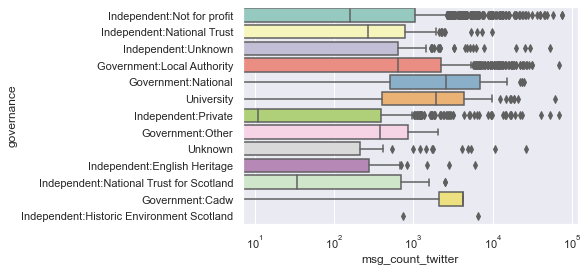


activity_stats_mus_groups ['governance_simpl']


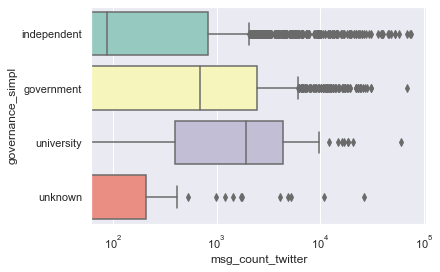


activity_stats_mus_groups ['size']


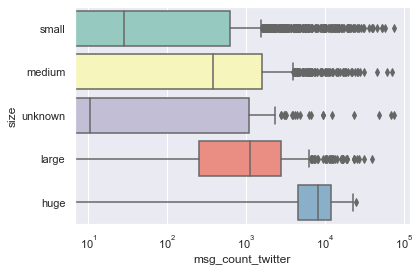


activity_stats_mus_groups ['subject_matter']


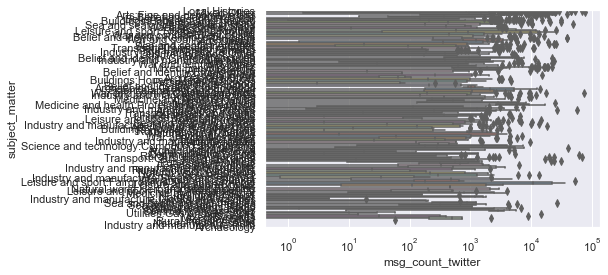


activity_stats_mus_groups ['accreditation']


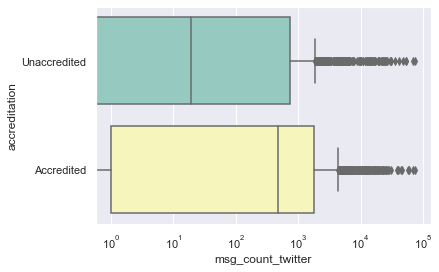


activity_stats_mus_groups ['region']


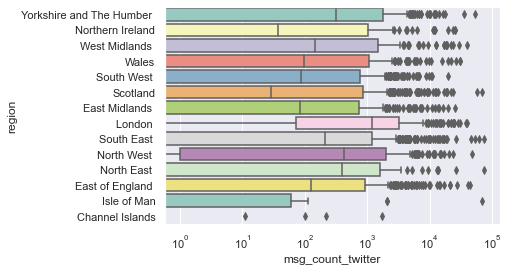


activity_stats_mus_groups ['country']


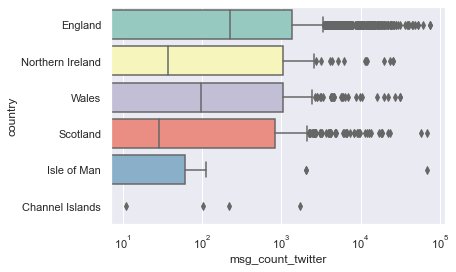


activity_stats_mus_groups ['subject_matter_simpl']


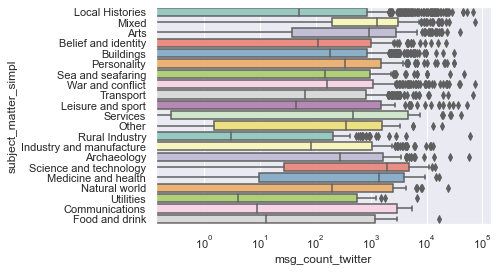


activity_stats_mus_groups ['governance', 'size']
plot_bivar_heatmap: governance-size msg_count_facebook_median
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance-size-msg_count_facebook_median.pdf
plot_bivar_heatmap: governance-size msg_count_facebook_mean
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance-size-msg_count_facebook_mean.pdf
plot_bivar_heatmap: governance-size msg_count_facebook_q75
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance-size-msg_count_facebook_q75.pdf
plot_bivar_heatmap: governance-size msg_count_facebook_active_mus_pc
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance-size-msg_count_facebook_active_mus_pc.pdf
plot_bivar_heatmap: governance-size msg_count_facebook_active_mus_pc_z
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance-size-msg_count_facebook_active_mus_pc_z.pdf
plot_bivar_heatmap: governance-size msg_count_fa

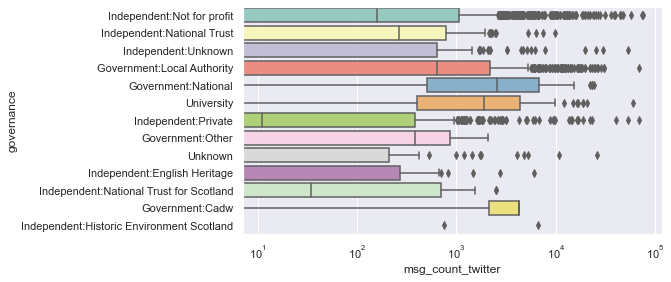

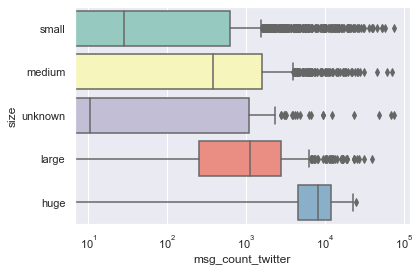


activity_stats_mus_groups ['governance_simpl', 'country']
plot_bivar_heatmap: governance_simpl-country msg_count_facebook_median
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance_simpl-country-msg_count_facebook_median.pdf
plot_bivar_heatmap: governance_simpl-country msg_count_facebook_mean
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance_simpl-country-msg_count_facebook_mean.pdf
plot_bivar_heatmap: governance_simpl-country msg_count_facebook_q75
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance_simpl-country-msg_count_facebook_q75.pdf
plot_bivar_heatmap: governance_simpl-country msg_count_facebook_active_mus_pc
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance_simpl-country-msg_count_facebook_active_mus_pc.pdf
plot_bivar_heatmap: governance_simpl-country msg_count_facebook_active_mus_pc_z
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__governance_si

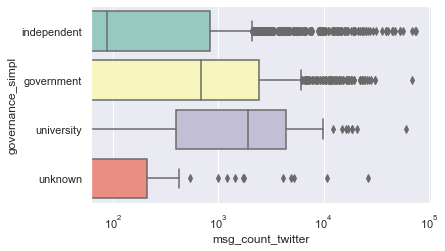

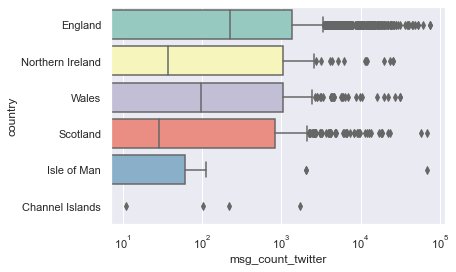


activity_stats_mus_groups ['region', 'size']
plot_bivar_heatmap: region-size msg_count_facebook_median
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__region-size-msg_count_facebook_median.pdf
plot_bivar_heatmap: region-size msg_count_facebook_mean
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__region-size-msg_count_facebook_mean.pdf
plot_bivar_heatmap: region-size msg_count_facebook_q75
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__region-size-msg_count_facebook_q75.pdf
plot_bivar_heatmap: region-size msg_count_facebook_active_mus_pc
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__region-size-msg_count_facebook_active_mus_pc.pdf
plot_bivar_heatmap: region-size msg_count_facebook_active_mus_pc_z
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__region-size-msg_count_facebook_active_mus_pc_z.pdf
plot_bivar_heatmap: region-size msg_count_facebook_msg_per_mus
../../data/analysis/temporal_

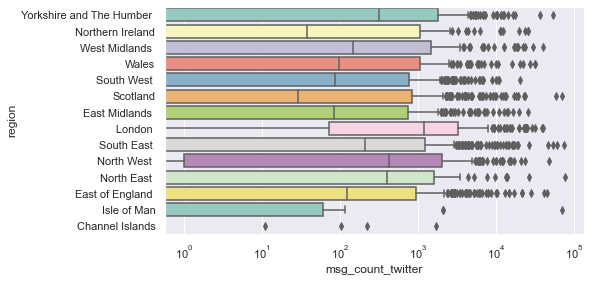

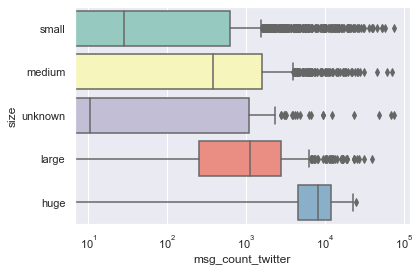


activity_stats_mus_groups ['country', 'size']
plot_bivar_heatmap: country-size msg_count_facebook_median
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__country-size-msg_count_facebook_median.pdf
plot_bivar_heatmap: country-size msg_count_facebook_mean
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__country-size-msg_count_facebook_mean.pdf
plot_bivar_heatmap: country-size msg_count_facebook_q75
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__country-size-msg_count_facebook_q75.pdf
plot_bivar_heatmap: country-size msg_count_facebook_active_mus_pc
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__country-size-msg_count_facebook_active_mus_pc.pdf
plot_bivar_heatmap: country-size msg_count_facebook_active_mus_pc_z
../../data/analysis/temporal_analysis/bivar_heatmaps/heatmap_bivar__country-size-msg_count_facebook_active_mus_pc_z.pdf
plot_bivar_heatmap: country-size msg_count_facebook_msg_per_mus
../../data/analys

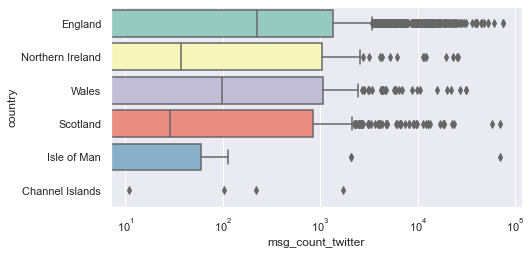

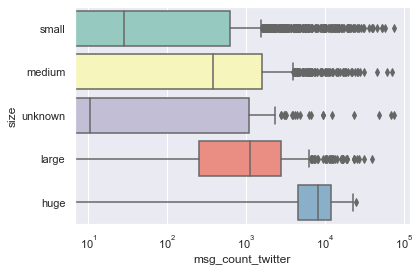

<Figure size 432x288 with 0 Axes>

In [184]:
# generate plots

var_combinations = [['governance'],['governance_simpl'],['size'],['subject_matter'],
        ['accreditation'],['region'],['country'],['subject_matter_simpl'],
        ['governance','size'],['governance_simpl','country'],['region','size'],
        ['country','size']]
#var_combinations = [['governance','region'],['size','governance_simpl']] # DEBUG

# generate all combinations
for attrs in var_combinations:
    # calc stats
    df = activity_stats_mus_groups(act_df, attrs)
    attrs_str = '-'.join(attrs)
    
    if len(attrs) == 2:
        # plot tables with heatmaps
        for plat in ['msg_count_facebook','msg_count_twitter']:
            for var in ['median','mean','q75','active_mus_pc','active_mus_pc_z','msg_per_mus']:
                target_var = plat + '_' + var
                plot_bivar_heatmap(df, attrs_str, target_var)
                
    fout = cur_folder+'/temporal_analysis/museum_activity_groups_var{}_{}.xlsx'.format(len(attrs), attrs_str)
    df.to_excel(fout,index=True)
    
    # plot
    if True:
        for att in attrs:
            ax = sns.boxplot(x="msg_count_twitter", y=att, # hue="governance",
                         data=act_df, palette="Set3")
            ax.set_xscale("log")
            plt.show()
            plt.clf()

### All tweets/posts over time

Summarise tweets using pandas aggregation.

In [9]:
def generate_time_plots(df, label, aggr_func):
    print('generate_time_plots', label)
    print('date range:', min(df.index), max(df.index))
    tdf = pd.DataFrame()
    for time_aggr in ['W','D','M','Q']:
        print(time_aggr)
        tmpdf = aggr_func(df, time_aggr)

        # plot tweets
        fig, ax = plt.subplots()
        tmpdf['count'].plot(linewidth=1, figsize=(20,7))
        plt.title('All museums - N={} - {} over time by {}'.format(len(df), label, time_aggr))
        plt.xlabel('Time')
        plt.grid(True, which='both')
        plt.ylabel('N  '+label)
        #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
        fig_fn = out_folder+'data/analysis/temporal_analysis/{}_temporal-all_mus-{}.pdf'.format(label,time_aggr)
        plt.savefig(fig_fn)
        print(fig_fn)
        #plt.show()
        
        plt.clf(); plt.cla(); plt.close()

        # add data
        tmpdf = tmpdf.reset_index()
        tdf.append(tmpdf)

    return tdf

def count_messages(df, time_aggr):
    tmpdf = df.resample(time_aggr).size().to_frame('count')
    tmpdf['time_unit'] = time_aggr
    return tmpdf

# generate tweet plots
df = pd.read_pickle(tw_fn)
print(len(df))
print(df.sample(10))
generate_time_plots(df, 'tweets', count_messages)

# generate facebook plots
df = pd.read_pickle(fb_fn)
print(len(df))
print(df.sample(10))
generate_time_plots(df, 'facebook_posts', count_messages)

5653012
                                museum_id          account
ts                                                        
2020-06-23 07:51:57+00:00  mm.domus.SC301  trimontiumtrust
2020-11-13 12:30:00+00:00     mm.musa.252      spacecentre
2021-08-11 14:19:20+00:00  mm.domus.NW165     lancsmuseums
2021-03-22 10:01:17+00:00  mm.domus.YH106          artfund
2019-05-07 01:11:23+00:00  mm.domus.SE410        metmuseum
2020-12-24 06:53:52+00:00      mm.mgs.345    eca_edinburgh
2020-07-09 10:08:30+00:00  mm.domus.SE377      kettlesyard
2021-01-11 15:46:13+00:00     mm.ace.1131     royalacademy
2021-06-04 12:00:11+00:00      mm.ace.042  haringeycouncil
2019-05-02 07:56:54+00:00   mm.aim82M.028      biker_nigel
generate_time_plots tweets
date range: 2019-01-01 00:00:00+00:00 2021-10-15 12:45:39+00:00
W
../../data/analysis/temporal_analysis/tweets_temporal-all_mus-W.pdf
D
../../data/analysis/temporal_analysis/tweets_temporal-all_mus-D.pdf
M
../../data/analysis/temporal_analysis/tweets_tempor

""


### Active museums over time

Count museums that are active on FB/TW in a give period

In [10]:
def count_museums(df, time_aggr):
    df = df[['museum_id']]
    tmpdf = df.resample(time_aggr).nunique()
    tmpdf.columns = ['count']
    tmpdf['time_unit'] = time_aggr
    return tmpdf

# generate tweet plots
df = pd.read_pickle(tw_fn)
print(len(df))
generate_time_plots(df, 'museums_on_tw', count_museums)

# generate facebook plots
df = pd.read_pickle(fb_fn)
print(len(df))
generate_time_plots(df, 'museums_on_fb', count_museums)

5653012
generate_time_plots museums_on_tw
date range: 2019-01-01 00:00:00+00:00 2021-10-15 12:45:39+00:00
W
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-W.pdf
D
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-D.pdf
M
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-M.pdf
Q
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-Q.pdf
1468515
generate_time_plots museums_on_fb
date range: 2019-01-01 00:00:00+00:00 2021-10-20 23:43:03+00:00
W
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-W.pdf
D
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-D.pdf
M
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-M.pdf
Q
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-Q.pdf


""


### Daily heatmaps

- Calplot package: https://www.analyticsvidhya.com/blog/2021/02/visualization-in-time-series-using-heatmaps-in-python/

In [14]:
!pip install calplot

In [51]:
import calplot

def plot_daily_heatmap(df, label):
    # count tweets per day
    cmap = None
    cdf = df[['museum_id']].resample('D').count()
    ax = calplot.calplot(cdf['museum_id'], yearlabels=True)
    fig_fn = out_folder+'data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_{}-msg.pdf'.format(label)
    plt.savefig(fig_fn)
    plt.clf()
    del cdf
    # count active museums per day
    mdf = df[['museum_id']].resample('D').nunique()
    ax = calplot.calplot(mdf['museum_id'], yearlabels=True)
    fig_fn = out_folder+'data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_{}-active_mus.pdf'.format(label)
    #plt.tight_layout()
    plt.savefig(fig_fn)
    print(fig_fn)
    plt.clf()
    del mdf

df = pd.read_pickle(tw_fn)
plot_daily_heatmap(df, 'twitter')

df = pd.read_pickle(fb_fn)
plot_daily_heatmap(df, 'facebook')

/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore

../../data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_twitter-active_mus.pdf


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore

../../data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_facebook-active_mus.pdf


<Figure size 900x367.2 with 0 Axes>

<Figure size 900x367.2 with 0 Axes>

<Figure size 900x367.2 with 0 Axes>

<Figure size 900x367.2 with 0 Axes>

End of notebook.